# CS 20 : TensorFlow for Deep Learning Research
## Lecture 3 : Linear and Logistic Regression
### Linear Regression with tf.data

**Reference**

* https://jhui.github.io/2017/11/21/TensorFlow-Importing-data/
* https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428
* https://stackoverflow.com/questions/47356764/how-to-use-tensorflow-dataset-api-with-training-and-validation-sets

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint
%matplotlib inline

print(tf.__version__)

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


### Build input pipeline

In [2]:
train_dir = os.listdir('../data/lec3_example_with_data/train_dir/')
train_dir = list(map(lambda path : '../data/lec3_example_with_data/train_dir/' + path, train_dir))
pprint(train_dir, compact = True)

['../data/lec3_example_with_data/train_dir/birth_life_2010_tr_1.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_10.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_11.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_12.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_13.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_14.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_2.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_3.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_4.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_5.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_6.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_7.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_8.txt',
 '../data/lec3_example_with_data/train_dir/birth_life_2010_tr_9.txt']


In [3]:
val_dir = '../data/lec3_example_with_data/val_dir/birth_life_2010_val.txt'
pprint(val_dir)

'../data/lec3_example_with_data/val_dir/birth_life_2010_val.txt'


In [4]:
# hyper parameters
epochs = 100
batch_size = 8

In [5]:
# datasets construction
# for training dataset
tr_dataset = tf.data.TextLineDataset(filenames = train_dir)
tr_dataset = tr_dataset.map(lambda record : tf.decode_csv(records = record,
                                                          record_defaults = [[''],[.0],[.0]],
                                                          field_delim = '\t')[1:])
tr_dataset = tr_dataset.shuffle(200)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

# for validation dataset
val_dataset = tf.data.TextLineDataset(filenames = val_dir)
val_dataset = val_dataset.map(lambda record : tf.decode_csv(records = record,
                                                          record_defaults = [[''],[.0],[.0]],
                                                          field_delim = '\t')[1:])
val_dataset = val_dataset.shuffle(200)
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

In [6]:
# handle constructions. Handle allows us to feed data from different dataset by providing a parameter in feed_dict 
handle = tf.placeholder(dtype = tf.string)
iterator = tf.data.Iterator.from_string_handle(string_handle = handle,
                                               output_types = tr_iterator.output_types)
X, Y = iterator.get_next()

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Define the graph of Simple Linear Regression

In [8]:
# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weight', initializer = tf.constant(.0))
b = tf.get_variable(name = 'bias', initializer = tf.constant(.0))

# construct model to predict Y
yhat = X * w + b

# use the square error as loss function
mse_loss = tf.reduce_mean(tf.square(Y - yhat))
mse_loss_summ = tf.summary.scalar(name = 'mse_loss', tensor = mse_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(mse_loss)

### Training

In [9]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_mse_with_tf_data/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_mse_with_tf_data/val',
                                     graph = tf.get_default_graph())

In [10]:
'''
# hyper parameters
epochs = 100
batch_size = 8
'''

tr_loss_hist = []
val_loss_hist = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # for mini-batch training
    sess.run(tr_iterator.initializer)
    try:
        while True:
            _, tr_loss, tr_loss_summ = sess.run(fetches = [training_op, mse_loss, mse_loss_summ], feed_dict = {handle : tr_handle})
            avg_tr_loss += tr_loss
            tr_step += 1

    except tf.errors.OutOfRangeError:
        pass
    
    # for validation
    sess.run(val_iterator.initializer)
    try:
        while True:
            val_loss, val_loss_summ = sess.run(fetches = [mse_loss, mse_loss_summ], feed_dict = {handle : val_handle})
            avg_val_loss += val_loss
            val_step += 1
    
    except tf.errors.OutOfRangeError:
        pass
    
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss : 1851.416, val_loss : 1258.365
epoch :  10, tr_loss : 362.732, val_loss : 355.376
epoch :  20, tr_loss : 122.671, val_loss : 116.312
epoch :  30, tr_loss : 60.569, val_loss : 44.755
epoch :  40, tr_loss : 40.674, val_loss : 26.667
epoch :  50, tr_loss : 34.943, val_loss : 21.573
epoch :  60, tr_loss : 35.697, val_loss : 21.261
epoch :  70, tr_loss : 32.887, val_loss : 20.199
epoch :  80, tr_loss : 36.242, val_loss : 21.096
epoch :  90, tr_loss : 33.832, val_loss : 22.281


### Visualization

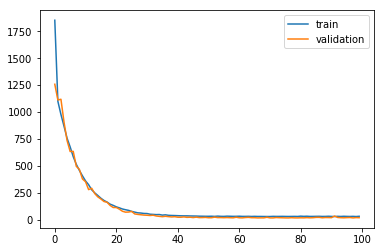

In [11]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

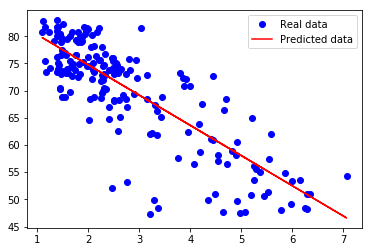

In [12]:
data = pd.read_table('../data/lec3_example_with_placeholder/birth_life_2010.txt') # loading data for Visualization
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()